In [36]:
import math
import numpy as np
import pandas as pd

# https://www.5axxw.com/wiki/content/aeduov
import pandas_ta as ta
import pandas_datareader.data as pdr

import datetime   
import fix_yahoo_finance as yf

from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

pd.set_option('display.max_columns',None) 

# Data Loading

In [2]:
# read data from previously downloaded files

# 7 advanced economies
df_US          = pd.read_csv('./US.csv')
df_Canada      = pd.read_csv('./Canada.csv')
df_Japan       = pd.read_csv('./Japan.csv')
df_Hong_Kong   = pd.read_csv('./Hong_Kong.csv')
df_Spain       = pd.read_csv('./Spain.csv')
df_France      = pd.read_csv('./France.csv')
df_Netherlands = pd.read_csv('./Netherlands.csv')

# 6 emerging economies
df_Brazil      = pd.read_csv('./Brazil.csv')
df_Mexico      = pd.read_csv('./Mexico.csv')
df_China       = pd.read_csv('./China.csv')
df_Turkey      = pd.read_csv('./Turkey.csv')
df_Indonesia   = pd.read_csv('./Indonesia.csv')
df_India       = pd.read_csv('./India.csv')

In [3]:
# create df_full containing data of all the economies
df_list     = [df_US,df_Canada,df_Japan,df_Hong_Kong,df_Spain,df_France,df_Netherlands,
               df_Brazil,df_Mexico,df_China,df_Turkey,df_Indonesia,df_India]
region_list = ['US','Canada','Japan','Hong_Kong','Spain','France','Netherlands',
               'Brazil','Mexico','China','Turkey','Indonesia','India']

# add region name and change col names
for df, region in zip(df_list, region_list):
    df['region'] = region
    df.rename(columns = {'Adj Close':'return_next_day','Date':'datetime','High':'high',
                         'Low':'low','Open':'open','Close':'close','Volume':'volume'}, 
              inplace = True)
    
# select the data within the observation period 2010-2020
for i, df in enumerate(df_list):
    selection_logic = (df.datetime >= '2010-01-01') & (df.datetime <= '2020-12-31')
    df_list[i] = df.loc[selection_logic,:].reset_index(drop=True)
    # create col 'return_next_day'
    df_list[i]['return_next_day'] = np.nan
    df_list[i].loc[:,'return_next_day'] = df_list[i]['close'].shift(-1)
    # df_list[i].loc[:,'return_next_day'] = df_list[i]['close'].shift(-1) - df_list[i]['close']
    
# df_full = pd.concat(df_list, ignore_index = True)
df_list[0]

,datetime,high,low,open,close,volume,return_next_day,region
0,2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3991400000,1136.520020,US
1,2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2491020000,1137.140015,US
2,2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4972660000,1141.689941,US
3,2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5270680000,1144.979980,US
4,2010-01-08,1145.390015,1136.219971,1140.520020,1144.979980,4389590000,1146.979980,US
...,...,...,...,...,...,...,...,...
2764,2020-12-24,3703.820068,3689.320068,3694.030029,3703.060059,1885090000,3735.360107,US
2765,2020-12-28,3740.510010,3723.030029,3723.030029,3735.360107,3527460000,3727.040039,US
2766,2020-12-29,3756.120117,3723.310059,3750.010010,3727.040039,3387030000,3732.040039,US
2767,2020-12-30,3744.629883,3730.209961,3736.189941,3732.040039,3145200000,3756.070068,US


In [4]:
# count how many instances in each region
print('How many instances in each dataset')
for region, df in zip(region_list, df_list):
    print('{:<12} {:>5d} '.format(region+':', df.shape[0]))

How many instances in each dataset
US:           2769 
Canada:       2760 
Japan:        2690 
Hong_Kong:    2705 
Spain:        2812 
France:       2810 
Netherlands:  2813 
Brazil:       2716 
Mexico:       2753 
China:        2670 
Turkey:       2762 
Indonesia:    2680 
India:        2701 


# Data Pre-processing

## technical indicators generation

In [5]:
# using pandas_ta package as the origion paper indicates
n = 10; k = 15

# create the custom strategy for 20 technical indicators
CustomStrategy = ta.Strategy(
    name = 'could use help(ta.xxx) to check the definition & calculation',
    ta=[
        {"kind": "sma",  "length": n},
        {"kind": "ema",  "length": n},
        {"kind": "macd", "fast"  : n , "slow": k},
        {"kind": "adx",  "length": n},
        {"kind": "cci",  "length": n},
        {"kind": "mom",  "length": n},
        {"kind": "roc",  "length": n},
        {"kind": "rsi",  "length": n},
        {"kind": "tsi",  "length": n},
        {"kind": "kdj",  "length": n}, # it includes k%, d%, j%
        {"kind": "atr",  "length": n},
        {"kind": "ui" ,  "length": n},
        {"kind": "ad" ,  "length": n},
        {"kind": "obv",  "length": n}]
)

# generate technical indicators
for i, df in enumerate(df_list):
    df_list[i].ta.strategy(CustomStrategy)

In [6]:
# clean dataframes
for i, df in enumerate(df_list):
    cols = ['region','datetime','return_next_day','high','low','open','close','SMA_10',
            'EMA_10','MACD_10_15_9','ADX_10','CCI_10_0.015','MOM_10','ROC_10','RSI_10',
            'TSI_13_25_13','K_10_3','D_10_3','J_10_3','ATRr_10','UI_10','AD','OBV']
    # delete rows b/c loosing obeservations
    df_list[i] = df_list[i].loc[24:df_list[i].shape[0]-2,cols].reset_index(drop=True)

df_list[0].head()

,region,datetime,return_next_day,high,low,open,close,SMA_10,EMA_10,MACD_10_15_9,ADX_10,CCI_10_0.015,MOM_10,ROC_10,RSI_10,TSI_13_25_13,K_10_3,D_10_3,J_10_3,ATRr_10,UI_10,AD,OBV
0,US,2010-02-08,1070.520020,1071.199951,1056.510010,1065.510010,1056.739990,1082.389990,1082.543306,-10.285084,57.587779,-126.654054,-40.040039,-3.650690,29.557233,-31.395445,23.118601,22.250833,24.854138,18.309764,4.539277,7.000802e+09,6.047570e+09
1,US,2010-02-09,1068.130005,1079.280029,1060.060059,1060.060059,1070.520020,1080.224988,1080.357254,-9.682590,55.953294,-62.030614,-21.650024,-1.982294,38.281123,-29.437032,29.819572,24.779520,39.899674,18.765509,4.352115,7.453144e+09,1.116183e+10
2,US,2010-02-10,1078.469971,1073.670044,1059.339966,1069.680054,1068.130005,1077.287988,1078.134118,-9.166996,54.612874,-63.139191,-29.369995,-2.676082,37.388797,-28.068852,32.959493,27.510335,43.857808,18.291329,4.225706,8.417354e+09,6.910380e+09
3,US,2010-02-11,1075.510010,1080.040039,1060.589966,1067.099976,1078.469971,1076.681982,1078.195182,-8.002039,52.043317,-22.071395,-6.060059,-0.558773,43.697528,-25.530705,40.776666,31.936939,58.456122,18.414358,3.886038,1.210772e+10,1.131125e+10
4,US,2010-02-12,1094.869995,1077.810059,1062.969971,1075.949951,1075.510010,1076.845984,1077.706969,-7.154351,49.815438,-23.171415,1.640015,0.152720,42.340556,-23.735646,44.347519,36.076600,60.889358,18.106827,3.365921,1.497868e+10,7.150570e+09


## normalization

In [7]:
# normalization
for i, df in enumerate(df_list):
    df_list[i].iloc[:,3:] = df_list[i].iloc[:,3:].apply(
        lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    
df_list[0].head()

#array_X = np.array(df_X_nor.T)
#array_y = np.array(df_y_nor.T)/1000 
# i think it would fit ANN more? ie., more close to 1?

,region,datetime,return_next_day,high,low,open,close,SMA_10,EMA_10,MACD_10_15_9,ADX_10,CCI_10_0.015,MOM_10,ROC_10,RSI_10,TSI_13_25_13,K_10_3,D_10_3,J_10_3,ATRr_10,UI_10,AD,OBV
0,US,2010-02-08,1070.520020,0.014046,0.016769,0.013907,0.012592,0.011971,0.011981,0.663575,0.852338,0.299200,0.597410,0.465038,0.234001,0.070086,0.198053,0.140825,0.341286,0.065068,0.242227,0.000000,0.000000
1,US,2010-02-09,1068.130005,0.017013,0.018075,0.011905,0.017672,0.011157,0.011159,0.667457,0.823227,0.412781,0.613287,0.504351,0.346376,0.089145,0.269842,0.170089,0.443280,0.067823,0.232220,0.000332,0.005466
2,US,2010-02-10,1078.469971,0.014953,0.017810,0.015439,0.016791,0.010053,0.010322,0.670780,0.799354,0.410833,0.606622,0.488003,0.334881,0.102459,0.303481,0.201692,0.470113,0.064957,0.225461,0.001039,0.000922
3,US,2010-02-11,1075.510010,0.017292,0.018269,0.014491,0.020602,0.009825,0.010345,0.678287,0.753590,0.483013,0.626746,0.537893,0.416145,0.127159,0.387229,0.252919,0.569076,0.065700,0.207301,0.003744,0.005626
4,US,2010-02-12,1094.869995,0.016473,0.019145,0.017742,0.019511,0.009887,0.010162,0.683750,0.713911,0.481080,0.633394,0.554659,0.398666,0.144628,0.425485,0.300826,0.585571,0.063842,0.179492,0.005849,0.001179


In [8]:
# there's a missing value issue, but with a very small proportion (5/2000)
# df_list_n[10]['UI_10'][df_list_n[10]['UI_10'].isna()==True]
print('How many missing values in each dataset')
for region, df in zip(region_list, df_list):
    print('{:<12} {:>5d} '.format(region+':', df.isna().sum().sum()))
    
# fill blanks using the most recent values
for i, df in enumerate(df_list):
    df_list[i]['UI_10'] = df_list[i]['UI_10'].fillna(method = 'ffill')
print('\nand all blanks have been filled')

How many missing values in each dataset
US:              0 
Canada:          0 
Japan:           2 
Hong_Kong:       5 
Spain:           0 
France:          0 
Netherlands:     0 
Brazil:          2 
Mexico:          0 
China:           0 
Turkey:          5 
Indonesia:       0 
India:           0 

and all blanks have been filled


## principal components analysis

In [9]:
def zeromean(dataframe):   
    """ 
    Args:    
    dataframe(pd.DataFrame)
    
    Returns:    
    dataframe_new(pd.DataFrame): de-meaned dataframe    
    mean(float): mean of each features
    """
    mean = np.mean(dataframe, axis = 0)     
    dataframe_new = dataframe - mean
    return dataframe_new, mean

def percentage_to_n(eig_vals, percentage):
    """
    Args:    
    eig_vals(np.array): eigenvalues of a matrix
    percentage(float): how much explanation needed
    
    Returns:    
    pca_num(int): how many eigenvectors needed to achieve the explanation
    """
    sort_eig_vals = np.sort(eig_vals)
    sort_eig_vals = sort_eig_vals[-1::-1]
    sum_eig_vals  = sum(sort_eig_vals)
    
    pca_sum = 0
    pca_num = 0
    
    for i in sort_eig_vals:
        pca_sum += i
        pca_num += 1
        if pca_sum >= sum_eig_vals * percentage:
            break
    
    return pca_num
 
def pca(dataframe, percentage = 0.99):
    """
    Args:    
    dataframe(pd.DataFrame)
    percentage(float): how much explanation needed
    
    Returns:    
    low_dimen_data(pd.DataFrame): dataframe after pca
    n(int): how many eigenvectors needed to achieve the explanation
    """
    dataframe_new, mean = zeromean(dataframe)
    
    cov_matrix = np.cov(dataframe_new, rowvar = 0)    
    eig_vals,eig_vects = np.linalg.eig(np.mat(cov_matrix))
    
    # choose how many pcs needed to explain 99%
    n = percentage_to_n(eig_vals, percentage)

    # choose top n
    eig_val_indice = np.argsort(eig_vals)
    n_eig_val_indice = eig_val_indice[-1:-(n+1):-1] 
    
    # reconstruct data
    n_eig_vect = eig_vects[:, n_eig_val_indice]
    low_dimen_data = dataframe_new @ n_eig_vect
    return low_dimen_data, n

In [10]:
# x partition and y partition
array_list_x = []
array_list_y = []

print('How many PCs extracted in each dataset for 99% explanation')
for region, df in zip(region_list, df_list):
    array_list_x.append(np.array(pca(df.iloc[:,3:])[0].T))
    print('{:<12} {:>5d} PCs '.format(region+':', pca(df.iloc[:,3:])[1]))

for region, df in zip(region_list, df_list):
    array_list_y.append(np.array(df.iloc[:,2].T))

How many PCs extracted in each dataset for 99% explanation
US:              8 PCs 
Canada:          8 PCs 
Japan:           8 PCs 
Hong_Kong:       9 PCs 
Spain:           9 PCs 
France:          9 PCs 
Netherlands:     8 PCs 
Brazil:          8 PCs 
Mexico:          9 PCs 
China:           8 PCs 
Turkey:          9 PCs 
Indonesia:       9 PCs 
India:           8 PCs 


In [11]:
# check dirty work using sklearn
from sklearn.decomposition import PCA
df_test = df_list[0].iloc[:,3:]
X = np.array(df_test)

pca = PCA(n_components=8)
pca_lib = pca.fit_transform(X)
pd.DataFrame(pca_lib).head()
# proved they are the same

,0,1,2,3,4,5,6,7
0,-1.259054,0.778901,0.216105,0.476754,-0.007245,-0.268125,0.036703,0.162534
1,-1.235716,0.599162,0.284994,0.449431,-0.064480,-0.231209,0.065403,0.154753
2,-1.232980,0.557111,0.278169,0.427872,-0.042229,-0.234233,0.034970,0.157879
3,-1.209271,0.380910,0.317534,0.381648,-0.061154,-0.217395,0.055226,0.154106
4,-1.203119,0.326902,0.290218,0.340068,-0.029309,-0.230123,0.050211,0.155465


# FFNN: Feed-Foreward

In [12]:
# this function defines sigmoid activation function: f(x) = 1 / (1 + e^(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# this function defines the derivative of sigmoid function
def deriv_sigmoid(x):
    fx = sigmoid(x)
    return fx * (1 - fx)

# this function defines the loss function, Mean Squared Error (MSE)
def MSE(y_true, y_prediction):
    return ((y_true - y_prediction) ** 2).mean()

In [13]:
# this function initialises the network with the structure of 5 layers
# n1 is the number of neurons at the 1st hidden layer
# n2 is the number of neurons at the 2nd hidden layer
# n3 is the number of neurons at the 3rd hidden layer

## could change the neurons at each layer here
n1,  n2,  n3  = 5, 5, 5
ann_structure = [n1, n2, n3]

def parameters_reset (n1, n2, n3) :
    """ 
    Args:    
    n1,n2,n3(int): 
    how many neurons on each hidden layer
    
    Returns:    
    W1,W2,W3,W4,b1,b2,b3,b4(float): 
    parameters set (same at the each time)
    """
    # show that we are changing the global variables
    global W1, W2, W3, W4, b1, b2, b3, b4
    
    # to keep the initial parameters the same
    np.random.seed(42)
    
    W1 = np.random.randn(n1, num_input) / 2
    W2 = np.random.randn(n2, n1) / 2
    W3 = np.random.randn(n3, n2) / 2
    W4 = np.random.randn(1 , n3) / 2
    
    b1 = np.random.randn(n1, 1 ) / 2
    b2 = np.random.randn(n2, 1 ) / 2
    b3 = np.random.randn(n3, 1 ) / 2
    b4 = np.random.randn(1 , 1 ) / 2
    
# parameters_reset (n1, n2, n3)
    
# dimensions = n1 * num_input + n2 * n1 + n3 * n2 + 1 * n3 + n1 + n2 + n3 + 1
# print('hi, under this setting, totally {:} dimensions of parameter'.format(dimensions))

In [14]:
# This function realizes the Feedforward
def forward_prop (a0, W1, W2, W3, W4, b1, b2, b3, b4) :
    """ 
    Args:    
    a0(np.array): dataset (* which should be transposed)
    W1,W2,W3,W4,b1,b2,b3,b4(float): parameters
    
    Returns:    
    a0(np.array): dataset as the same as the input
    s1,a1,s2,a2,s3,a3,s4(np.array): results of FFNN
    """
    s1 = W1 @ a0 + b1
    a1 = sigmoid(s1) 
    s2 = W2 @ a1 + b2
    a2 = sigmoid(s2)
    s3 = W3 @ a2 + b3
    a3 = sigmoid(s3)
    s4 = W4 @ a3 + b4
    # since this is not a classification problem
    # I do not put activation function on the output layer
    
    # return multiple values
    return a0, s1, a1, s2, a2, s3, a3, s4

# Jacobian Matrixes Set-up

In [17]:
# Jacobian for the weights of the output layer
def J_W4 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4) 
    # d s4/w4 = a3
    J = J @ a3.T / x.shape[1]
    return J

# Jacobian for the bias of the output layer
def J_b4 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/b4 = 1
    J = np.sum(J, axis=1, keepdims=True) / x.shape[1]
    return J

In [18]:
# Jacobian for the weights of the 3rd hidden layer
def J_W3 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/a3 = W4
    J = (J.T @ W4).T
    # d a3/s3 = s'(s3)
    J = J * deriv_sigmoid(s3)
    # d s3/W3 = a2
    J = J @ a2.T / x.shape[1]
    return J

# Jacobian for the bias of the 3rd hidden layer
def J_b3 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/a3 = W4
    J = (J.T @ W4).T
    # d a3/s3 = s'(s3)
    J = J * deriv_sigmoid(s3)   
    # d s3/b3 = 1
    J = np.sum(J, axis=1, keepdims=True) / x.shape[1]
    return J

In [19]:
# Jacobian for the weights of the 2nd hidden layer
def J_W2 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/a3 = W4
    J = (J.T @ W4).T
    # d a3/s3 = s'(s3)
    J = J * deriv_sigmoid(s3)
    # d s3/a2 = W3
    J = (J.T @ W3).T    
    # d a2/s2 = s'(s2)
    J = J * deriv_sigmoid(s2)  
    # d s2/W2 = a1
    J = J @ a1.T / x.shape[1]
    return J

# Jacobian for the biases of the 2nd hidden layer
def J_b2 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/a3 = W4
    J = (J.T @ W4).T
    # d a3/s3 = s'(s3)
    J = J * deriv_sigmoid(s3)
    # d s3/a2 = W3
    J = (J.T @ W3).T    
    # d a2/s2 = s'(s2)
    J = J * deriv_sigmoid(s2)  
    # d s2/b2 = 1
    J = np.sum(J, axis=1, keepdims=True) / x.shape[1]
    return J

In [20]:
# Jacobian for the weights of the 1st hidden layer
def J_W1 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/a3 = W4
    J = (J.T @ W4).T
    # d a3/s3 = s'(s3)
    J = J * deriv_sigmoid(s3)
    # d s3/a2 = W3
    J = (J.T @ W3).T    
    # d a2/s2 = s'(s2)
    J = J * deriv_sigmoid(s2)  
    # d s2/a1 = W2
    J = (J.T @ W2).T   
    # d a1/s1 = s'(s1)
    J = J * deriv_sigmoid(s1)   
    # d s1/W1 = a0
    J = J @ a0.T / x.shape[1]
    return J    

# Jacobian for the biases of the 1st hidden layer
def J_b1 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/a3 = W4
    J = (J.T @ W4).T
    # d a3/s3 = s'(s3)
    J = J * deriv_sigmoid(s3)
    # d s3/a2 = W3
    J = (J.T @ W3).T    
    # d a2/s2 = s'(s2)
    J = J * deriv_sigmoid(s2)  
    # d s2/a1 = W2
    J = (J.T @ W2).T   
    # d a1/s1 = s'(s1)
    J = J * deriv_sigmoid(s1)   
    # d s1/b1 = 1
    J = np.sum(J, axis=1, keepdims=True) / x.shape[1]
    return J

# Particle Swarm Optimization

In [15]:
# this function calculate MSE without gradient components
def MSE_calculation_in_PSO(array_x, array_y, paras):
    """ 
    Args:    
    array_x(np.array): dataset (* which should be transposed)
    array_y(np.array): true values (* which should be transposed)
    paras(np.array): parameters
    
    Returns:    
    MSE(float): MSE at the input parameters
    """
    num_input = array_x.shape[0]
    # transform parameters from vector to matrix
    t1 = n1 * num_input
    t2 = t1 + n2 * n1
    t3 = t2 + n3 * n2
    t4 = t3 + n3
    t5 = t4 + n1
    t6 = t5 + n2
    t7 = t6 + n3
    t8 = t7 + 1
    
    return MSE(array_y, forward_prop(array_x, 
                                        paras[0  : t1].reshape(n1 , num_input), 
                                        paras[t1 : t2].reshape(n2 , n1), 
                                        paras[t2 : t3].reshape(n3 , n2), 
                                        paras[t3 : t4].reshape(1  , n3), 
                                        paras[t4 : t5].reshape(n1 ,  1), 
                                        paras[t5 : t6].reshape(n2 ,  1), 
                                        paras[t6 : t7].reshape(n3 ,  1), 
                                        paras[t7 : t8].reshape(1  ,  1))[7])

In [16]:
def pso(array_x, array_y):
    """ 
    Args:    
    array_x(np.array): dataset (* which should be transposed)
    array_y(np.array): true values (* which should be transposed)
    
    Returns:    
    W1_pso, W2_pso, W3_pso, W4_pso, b1_pso, b2_pso, b3_pso, b4_pso(np.array): 
    parameters found by PSO
    """
    # 1. initialize the particles
    np.random.seed(42)
    
    n_particles = 50
    num_input   = array_x.shape[0]
    dimensions  = n1 * num_input + n2 * n1 + n3 * n2 + 1 * n3 + n1 + n2 + n3 + 1

    # coordinate, [0,1]
    X = np.random.rand (dimensions, n_particles) / 2
    # velocity, from normal distribution
    V = np.random.randn(dimensions, n_particles) / 10

    # 2. period 1 initialization
    
    # p_best_loc: personal best location
    # p_best_obj: personal best objective function value
    # g_best_loc: global best location
    # g_best_obj: global best objective function value

    p_best_loc = X
    p_best_obj = np.array([MSE_calculation_in_PSO(array_x, array_y, paras) for paras in X.T])
    g_best_loc = p_best_loc[:,p_best_obj.argmin()]
    g_best_obj = p_best_obj.min()
    
    # print('hi, at the initialization, PSO finds {:4f} as MSE'.format(g_best_obj))
    
    # 3. algorithm
    
    # parameters setting
    # w: the inertia weight constant
    # it decides how much the particle should keep on with its previous velocity
    # c1: cognitive coefficient
    # it decides how much the particle should insist the search result of the particle
    # c2: social coefficients
    # it decides how much the particle should insist the search result of the swarm

    w, c1, c2, seed = 0.8, 0.1, 0.1, 0

    # iterations
    for i in range(100):
    
        # randomness in c1, c2
        np.random.seed(seed)
        r = np.random.rand(2)
    
        # velocity update
        V = w * V + c1 * r[0] * (p_best_loc - X) + \
                    c2 * r[1] * (g_best_loc.reshape(-1,1) - X)
        # position update
        X = X + V
    
        # objective at this round
        obj = np.array([MSE_calculation_in_PSO(array_x, array_y, paras) for paras in X.T])
    
        # personal best location update
        p_best_loc[:, (obj <= p_best_obj)] = X[:, (obj <= p_best_obj)]
        # personal best value update
        p_best_obj = np.array([p_best_obj, obj]).min(axis=0)
        # global best location update
        g_best_loc = p_best_loc[:,p_best_obj.argmin()]
        # global best value update
        g_best_obj = p_best_obj.min()
    
        seed += 1
    
        # print('hi, at the interation of {:}, PSO finds {:.4f} as MSE'.format(i+1, g_best_obj))
    
    t1 = n1 * num_input
    t2 = t1 + n2 * n1
    t3 = t2 + n3 * n2
    t4 = t3 + n3
    t5 = t4 + n1
    t6 = t5 + n2
    t7 = t6 + n3
    t8 = t7 + 1

        
    W1_pso = g_best_loc[0  : t1].reshape(n1 , num_input)
    W2_pso = g_best_loc[t1 : t2].reshape(n2 , n1)
    W3_pso = g_best_loc[t2 : t3].reshape(n3 , n2)
    W4_pso = g_best_loc[t3 : t4].reshape(1  , n3)
    b1_pso = g_best_loc[t4 : t5].reshape(n1 ,  1)
    b2_pso = g_best_loc[t5 : t6].reshape(n2 ,  1)
    b3_pso = g_best_loc[t6 : t7].reshape(n3 ,  1)
    b4_pso = g_best_loc[t7 : t8].reshape(1  ,  1)
    
    return W1_pso, W2_pso, W3_pso, W4_pso, b1_pso, b2_pso, b3_pso, b4_pso

    # print('\nthe optimal parameters have been kept within those suffixed as "_pso"')

# MB Stochastic Gradient Descent

In [21]:
# define the function that randomly sorts the data batches (size > 1)
# note: the data strcuture of X and y should be DataFrame
def batches(X, y, size, seed):
    """ 
    Args:    
    X(pd.DataFrame): dataset (* which should NOT be transposed)
    y(pd.DataFrame): true values (* which should NOT be transposed)
    
    Returns:    
    batches_full(list): data batches
    """
    # 1.fix this random seed at this moment, and this will be changed for each iteration
    np.random.seed(seed)
    # 2.number of total instances
    num_instances = X.shape[0]
    # 3.list initialized
    batches_full  = []
    
    # 4.shuffle X and y 
    shuf_order = list(np.random.permutation(num_instances))
    shuf_X     = X.iloc[shuf_order,:]
    shuf_y     = y.iloc[shuf_order,:]
    
    # 5.get the maximum number of the batches could be reached
    num_batch  = math.floor(num_instances / size) 
    
    # 6.get the new sorted batches
    for k in range(num_batch):
        batches_X = shuf_X.iloc[k*size : (k+1)*size-1 ,:]
        batches_y = shuf_y.iloc[k*size : (k+1)*size-1 ,:]
        batches   = (batches_X, batches_y)
        batches_full.append(batches)
        
    # 7.get the last remaining batch
    if num_instances % size != 0:
        batches_X = shuf_X.iloc[size * num_batch:,:]
        batches_y = shuf_y.iloc[size * num_batch:,:]
        batches   = (batches_X, batches_y)
        batches_full.append(batches)
        
    return batches_full

# FFNN: Back-Propogation

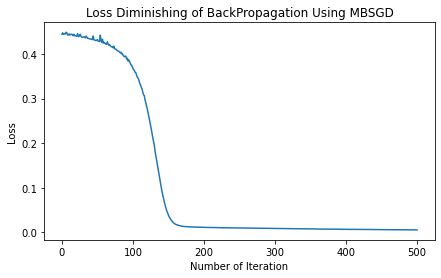

In [28]:
# optimze FFNN using MBSGD

# test using US dataset
array_x = array_list_x[0]
array_y = array_list_y[0]/1000

# 1.MBSGD parameters setting
learn_rate      = 0.1
total_iteration = 500
batch_size      = 512
seed_bp         = 0

# 2.initialize parameters using _pso
W1, W2, W3, W4, b1, b2, b3, b4 = pso(array_x, array_y)

# 3.read ANN parameters from PSO and feedforeward
a0, s1, a1, s2, a2, s3, a3, s4 = forward_prop(array_x, W1, W2, W3, W4, b1, b2, b3, b4)

# 4.keep the initial loss
loss_bp = [MSE(array_y, s4)]

# 5.reset dataset for MINIBATCH algorithm
df_X  = pd.DataFrame(array_x.T)
df_y  = pd.DataFrame(array_y.T)

# 6.backpropogation using MBSGD
for i in range (total_iteration): 
    # split data into batches
    for Batch in batches (df_X, df_y, size = batch_size, seed = seed_bp):
        
        # get data batches
        (Batch_X, Batch_y) = Batch
        # transform datches into arrays
        Batch_X = np.array(Batch_X).T
        Batch_y = np.array(Batch_y).T
        
        # parameters update
        a0, s1, a1, s2, a2, s3, a3, s4 = forward_prop(Batch_X, W1, W2, W3, W4, b1, b2, b3, b4)
        W1 -= learn_rate * J_W1 (a0, Batch_y)
        W2 -= learn_rate * J_W2 (a0, Batch_y)
        W3 -= learn_rate * J_W3 (a0, Batch_y)
        W4 -= learn_rate * J_W4 (a0, Batch_y)
        b1 -= learn_rate * J_b1 (a0, Batch_y)
        b2 -= learn_rate * J_b2 (a0, Batch_y)
        b3 -= learn_rate * J_b3 (a0, Batch_y)
        b4 -= learn_rate * J_b4 (a0, Batch_y)
        
    # at the end of each iteration, we keep the loss for the all the instances
    a0, s1, a1, s2, a2, s3, a3, s4 = forward_prop(array_x, W1, W2, W3, W4, b1, b2, b3, b4)
    loss = MSE(array_y, s4)
    loss_bp.append(loss)
    
    seed_bp += 1
    # print('at the interation of {:}, MBSGD finds {:.4f} as MSE'.format(i+1, loss))

# 6.plot the diagram of iteration and lossfuntion
plt.figure(figsize = (7,4))
plt.title("Loss Diminishing of BackPropagation Using MBSGD")
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')
plt.plot(range(501), loss_bp)

# Augmented Dicky–Fuller Test

In [141]:
# make copies for ARDL model
array_list_x_ARDL = array_list_x.copy()
array_list_y_ARDL = array_list_y.copy()

In [146]:
# create ADF table on PCs
ADF_result = []

for i, region in enumerate(region_list):
    ADF_result.append([region, 'CL', int(i), int(100), # index y using 100
                       adfuller(array_list_y_ARDL[i], autolag='AIC')[0],
                       adfuller(array_list_y_ARDL[i], autolag='AIC')[1]])
    for j in range(len(array_list_x_ARDL[i])):
        ADF_result.append([region, 'PC' + '_' + str(j+1), int(i), int(j),
                           adfuller(array_list_x_ARDL[i][j], autolag='AIC')[0],
                           adfuller(array_list_x_ARDL[i][j], autolag='AIC')[1]])

ADF_table = pd.DataFrame(ADF_result, columns=[
    'region','series','index_1','index_2','t_statistic','p_value'])
ADF_table[['t_statistic','p_value']] = ADF_table[['t_statistic','p_value']].round(2)

# check stationarity at the significance level of 5%
ADF_table[ADF_table.p_value > 0.05]

,region,series,index_1,index_2,t_statistic,p_value
0,US,CL,0,100,0.57,0.99
1,US,PC_1,0,0,0.24,0.97
8,US,PC_8,0,7,-2.41,0.14
9,Canada,CL,1,100,-1.71,0.43
10,Canada,PC_1,1,0,-1.36,0.60
18,Japan,CL,2,100,-0.44,0.90
19,Japan,PC_1,2,0,-0.57,0.88
27,Hong_Kong,CL,3,100,-2.37,0.15
28,Hong_Kong,PC_1,3,0,-2.55,0.10
31,Hong_Kong,PC_4,3,3,-2.52,0.11


In [147]:
# make difference series of y
ADF_1_diff = []
array_list_y_ARDL_1_diff = array_list_y_ARDL.copy()

for i in range(len(array_list_y_ARDL)):
    array_list_y_ARDL_1_diff[i] = np.diff(array_list_y_ARDL[i])
    
for i, region in enumerate(region_list):
    ADF_1_diff.append([region, 'CL', int(i), int(100),
                              adfuller(array_list_y_ARDL_1_diff[i], autolag='AIC')[0],
                              adfuller(array_list_y_ARDL_1_diff[i], autolag='AIC')[1]])

# make difference series of non-stationary x
array_list_x_ARDL_1_diff = array_list_x_ARDL.copy()

for i in range(len(array_list_y_ARDL)):
    array_list_x_ARDL_1_diff[i] = np.diff(array_list_x_ARDL[i])
    
index_non_stationary = np.array( \
ADF_table[(ADF_table.p_value > 0.05) & (ADF_table.index_2 != 100)][['index_1','index_2']])

for i, j in index_non_stationary:
    ADF_1_diff.append([region_list[i], 'PC' + '_' + str(j+1), int(i), int(j),
                              adfuller(array_list_x_ARDL_1_diff[i][j], autolag='AIC')[0],
                              adfuller(array_list_x_ARDL_1_diff[i][j], autolag='AIC')[1]])  

# make a table for these
ADF_1_diff_table = pd.DataFrame(ADF_1_diff,
                         columns=['region','series','index_1','index_2',
                                  't_statistic','p_value'])

ADF_1_diff_table[['t_statistic','p_value']] = \
ADF_1_diff_table[['t_statistic','p_value']].round(2)

In [148]:
# check if 1st differenced series work
ADF_result_table = pd.merge(left  = ADF_table,
                            right = ADF_1_diff_table,
                            on = ['region','series','index_1','index_2'],
                            how = 'left',
                            suffixes=['', '_1st_diff'])

ADF_result_table[ADF_result_table.p_value > 0.05]

,region,series,index_1,index_2,t_statistic,p_value,t_statistic_1st_diff,p_value_1st_diff
0,US,CL,0,100,0.57,0.99,-11.22,0.0
1,US,PC_1,0,0,0.24,0.97,-12.51,0.0
8,US,PC_8,0,7,-2.41,0.14,-13.95,0.0
9,Canada,CL,1,100,-1.71,0.43,-10.81,0.0
10,Canada,PC_1,1,0,-1.36,0.60,-11.74,0.0
18,Japan,CL,2,100,-0.44,0.90,-35.17,0.0
19,Japan,PC_1,2,0,-0.57,0.88,-19.87,0.0
27,Hong_Kong,CL,3,100,-2.37,0.15,-51.21,0.0
28,Hong_Kong,PC_1,3,0,-2.55,0.10,-14.58,0.0
31,Hong_Kong,PC_4,3,3,-2.52,0.11,-15.13,0.0


In [208]:
# stationary dataset
array_list_y_ARDL_sta = array_list_y_ARDL_1_diff.copy()

array_list_x_ARDL_sta = array_list_x.copy()

for i in range(len(region_list)):
    # delete first obs for all series, including stationary ones
    array_list_x_ARDL_sta[i] = np.delete(array_list_x_ARDL_sta[i], 0, axis=1)
    for j in range(len(array_list_x_ARDL[i])):
        # transform non-stationary into stationary ones
        if (i,j) in [(i[0],i[1]) for i in index_non_stationary]:
            array_list_x_ARDL_sta[i][j] = array_list_x_ARDL_1_diff[i][j]

# Auto-Regressive Distributed Lag Model

# Visualizations of Model Performance

# Appendix

## data extraction at the first semester

In [ ]:
import pandas as pd
import pandas_datareader.data as pdr

import datetime   
import fix_yahoo_finance as yf   
  
start = datetime.datetime(2009,  1,  1)   
end   = datetime.datetime(2021,  9,  1)   

In [83]:
symbol_dict = {'US':'^GSPC',        'Canada':'^GSPTSE',  'Japan':'^N225',     'Hong Kong':'^HSI',
               'Spain':'^OMX',      'France':'^FCHI',    'Netherlands':'^AEX','Spain':'^IBEX',
               # advanced
               'Brazil':'^BVSP',    'Mexico':'^MXX',     'China':'000001.SS', 'Turkey':'XU100.IS',
               'Indonesia':'^JKII', 'India':'^BSESN'}
               # emerging

data_list   = [i for i in range(14)]
i = 0

In [84]:
for con, sym in symbol_dict.items():
    data_list[i] = pd.DataFrame(pdr.get_data_yahoo(sym,start,end))
    i = i + 1
    #print("country: {}, symbol: {}, first record: {}, last record: {}".format(
    #con, sym, con.index[0].date(), con.index[-1].date()))
    print(con, sym, pdr.get_data_yahoo(sym,start,end).index[0].date(), pdr.get_data_yahoo(sym,start,end).index[-1].date())

US ^GSPC 2008-12-31 2021-09-01
Canada ^GSPTSE 2008-12-31 2021-09-01
Japan ^N225 2009-01-05 2021-09-01
Hong Kong ^HSI 2009-01-02 2021-09-01
Spain ^IBEX 2009-01-02 2021-09-01
France ^FCHI 2008-12-31 2021-09-01
Netherlands ^AEX 2008-12-31 2021-09-01
Brazil ^BVSP 2009-01-02 2021-09-01
Mexico ^MXX 2008-12-31 2021-09-01
China 000001.SS 2009-01-05 2021-09-01
Turkey XU100.IS 2008-12-31 2021-09-01
Indonesia ^JKII 2009-01-05 2021-09-01
India ^BSESN 2009-01-02 2021-09-01


In [90]:
df_US          = data_list[0]
df_Canada      = data_list[1]
df_Japan       = data_list[2]
df_Hong_Kong   = data_list[3]
df_Spain       = data_list[4]
df_France      = data_list[5]
df_Netherlands = data_list[6]
df_Brazil      = data_list[7]
df_Mexico      = data_list[8]
df_China       = data_list[9]
df_Turkey      = data_list[10]
df_Indonesia   = data_list[11]
df_India       = data_list[12]

In [94]:
df_US.to_csv('./US.csv')
df_Canada.to_csv('./Canada.csv')
df_Japan.to_csv('./Japan.csv')
df_Hong_Kong.to_csv('./Hong_Kong.csv')
df_Spain.to_csv('./Spain.csv')
df_France.to_csv('./France.csv')
df_Netherlands.to_csv('./Netherlands.csv')
df_Brazil.to_csv('./Brazil.csv')
df_Mexico.to_csv('./Mexico.csv')
df_China.to_csv('./China.csv')
df_Turkey.to_csv('./Turkey.csv')
df_Indonesia.to_csv('./Indonesia.csv')
df_India.to_csv('./India.csv')

## generate 20 technical indicators (dirty work)

In [ ]:
n = 10
k = 15

# 1.SMAt(n)
for region in region_list: 
    df_full.loc[df_full.Region == region,'SMA'] = \
    df_full[df_full.Region == region]['Close'].rolling(window = n).mean()

# 2.EMAt(n)
alpha_1 = 2/(n+1)
for region in region_list: 
    df_full.loc[df_full.Region == region,'EMA_10'] = \
    df_full.loc[df_full.Region == region,'Close'].ewm(alpha=alpha_1,adjust=False).mean()

alpha_2 = 2/(k+1)
for region in region_list: 
    df_full.loc[df_full.Region == region,'EMA_15'] = \
    df_full.loc[df_full.Region == region,'Close'].ewm(alpha=alpha_2,adjust=False).mean()
    
# 3.MACDt(n,k)
for region in region_list: 
    df_full.loc[df_full.Region == region,'MACD'] = \
    df_full.loc[df_full.Region == region,'EMA_10'] - \
    df_full.loc[df_full.Region == region,'EMA_15']

# 4.ATRt(n)
# TR
for region in region_list: 
    df_full.loc[df_full.Region == region, 'TR'] = \
    pd.concat([(df_full.loc[df_full.Region == region]['High'] - df_full.loc[df_full.Region == region]['Low']),
                abs(df_full.loc[df_full.Region == region]['High'] - df_full.loc[df_full.Region == region]['Close'].shift(+1)),
                abs(df_full.loc[df_full.Region == region]['Low']  - df_full.loc[df_full.Region == region]['Close'].shift(+1))], \
              axis = 1).max(axis=1)
    
df_full.head()